In [ ]:
import torch

In [ ]:
del q,k,qk

In [ ]:
# Load from .pt
q = torch.load("/content/drive/MyDrive/samples_bench/q_sample/610.pt",  map_location=torch.device('cpu'))
k = torch.load("/content/drive/MyDrive/samples_bench/k_sample/610.pt",  map_location=torch.device('cpu'))
qk = torch.load("/content/drive/MyDrive/samples_bench/qk_sample/610.pt",  map_location=torch.device('cpu'))


<ipython-input-5-9d81fd4517d2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q = torch.load("/content/drive/MyDrive/samples_bench/q_sample/610.pt",  map_location=torch.de

In [ ]:
q.shape

torch.Size([1, 32, 610, 128])

In [ ]:
q = abs(q)
k = abs(k)

In [ ]:
qk_thresh =  0.0100701507180929000
k_thresh = 2.62498951
q_thresh = 1.453121901

In [ ]:
k_mask = k < k_thresh
q_mask = q < q_thresh
qk_mask = qk < qk_thresh
k_mask = k_mask.reshape(32, 610, 128).to(torch.int32) * 1
q_mask = q_mask.reshape(32, 610, 128).to(torch.int32) * 1
qk_mask = qk_mask.reshape(32, 610, 610).to(torch.int32) * 1

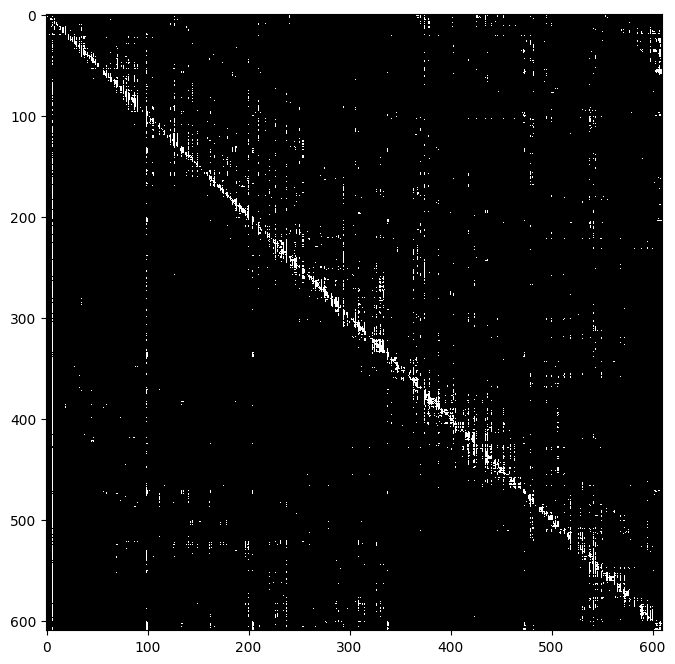

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define block size (n, m)
n, m = 1, 1

# Get tensor shape
tensor = qk_mask[0]

#
rows, cols = tensor.shape

# Calculate number of n x m blocks
num_blocks_row = rows // n
num_blocks_col = cols // m

# Initialize binary matrix to store if block contains any non-zero
block_status = np.zeros((num_blocks_row, num_blocks_col))

# Iterate over blocks and check for zero/non-zero elements
for i in range(num_blocks_row):
    for j in range(num_blocks_col):
        block = tensor[i*n:(i+1)*n, j*m:(j+1)*m]
        block_status[i, j] = 1 if torch.any(block != 0) else 0

# Plot the binary heatmap
plt.figure(figsize=(8, 8))
plt.imshow(block_status, cmap='binary', interpolation='nearest')
plt.show()


In [ ]:
!pip install torchshow

In [ ]:
tensor = 610-torch.sum(k_mask[31], dim=-2, keepdim=False)
num_non_zeros = torch.count_nonzero(tensor)

# Calculate the number of zeros
num_zeros = tensor.numel() - num_non_zeros
num_zeros

tensor(46)

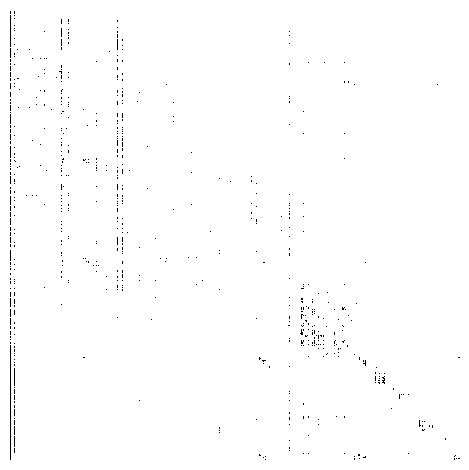

In [ ]:
import torchshow
import matplotlib.pyplot as plt
torchshow.show(qk_mask[12])

In [ ]:
import torch_blocksparse

In [ ]:
!pip install torch-blocksparse

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.9 MB/s eta 0:00:00
  Created wheel for torch-blocksparse: filename=torch_blocksparse-1.1.1-cp310-cp310-linux_x86_64.whl size=2770085 sha256=9eeae43dc3aba5465648e3cf08b39507859c54d9e42659a070d8ee51597147a0
  Stored in directory: /root/.cache/pip/wheels/21/c1/12/a564e4a62be0c27a12d8597d7a73c93c2f4dacb9ac2bb6438c
Successfully built torch-blocksparse


In [ ]:
torch.device('cuda')

device(type='cuda')

In [ ]:
import triton

In [ ]:
a = torch.rand(8, 32, 4096, 128)
b = torch.rand(8, 32, 4096, 128)

In [ ]:
c = torch.matmul(a, b.transpose(-1, -2))

In [ ]:
Z, H, M, N, K = 8, 32, 128, 128, 2000
a = torch.rand((Z, H, M, K), dtype=torch.float32).cuda()
b = torch.rand((Z, H, K, N), dtype=torch.float32).cuda()
# create sparsity layout
block = 16
layout = torch.randint(0, 2, (H, M//block, N//block))
# create object for Sparse = trans(Dense) x Dense (sdd)
# some overhead there as it pre-computes look-up tables
# internally needed by GPU kernels
dot = torch_blocksparse.MatMul(layout, block, 'dsd', trans_a=False, trans_b=False)
c = dot(a, b)

AttributeError: module 'triton' has no attribute 'kernel'

In [ ]:
import torch
import triton

M, N, K = 1024, 1024, 512  # A is MxN, B is NxK, C is MxK
block_size = 16
num_blocks_m = M // block_size
num_blocks_n = N // block_size

# Assume we have a layout bs_layout as defined above.

# Prepare the block-sparse data for A:
# For each True block in layout, create a 16x16 data block.
# Let's say we start with a dense A and then extract the blocks:
dense_A = torch.randn(M, N, device='cuda', dtype=torch.float16)
data_A = triton.ops.blocksparse.compact(dense_A, bs_layout)
# data_A now holds only the non-zero blocks from dense_A

# Prepare a dense B
B = torch.randn(N, K, device='cuda', dtype=torch.float16)

# We want to compute C = A_sparset * B
C = torch.zeros(M, K, device='cuda', dtype=torch.float16)

# Perform SpMM
triton.ops.blocksparse.spmm(
    layout=bs_layout,    # block-sparse layout
    data=data_A,         # flattened non-zero block data of A
    other=B,             # dense matrix B
    out=C,               # output matrix
    trans_a=False,       # whether A is transposed
    trans_b=False        # whether B is transposed
)

In [ ]:
!pip install torchshow

In [ ]:
import torch
import triton
import triton.ops.blocksparse as blocksparse

# Create input tensors on GPU
A = torch.rand(256, 128, 50, device='cuda', dtype=torch.float16)
B = torch.rand(256, 50, 128, device='cuda', dtype=torch.float16)

# Dimensions per batch element:
# A: (128, 50)
# B: (50, 128)
# The result per element: C: (128, 128)

# Choose a block size that divides both dimensions of A
block_size = 2
M, N = A.shape[1], A.shape[2]   # M=128, N=50
M_blocks = M // block_size       # 128/2 = 64
N_blocks = N // block_size       # 50/2 = 25

# Create a random block-sparse layout (e.g., 50% density)
density = 0.5
layout = (torch.rand(M_blocks, N_blocks, device='cuda') < density).bool()

# Convert layout into a Triton block layout
bs_layout = blocksparse.block_layout(layout, block_size)

# Allocate output tensor
C_all = torch.empty(256, 128, 128, device='cuda', dtype=torch.float16)

# Perform the block-sparse multiplication for each batch element
for i in range(256):
    # Compact the i-th slice of A into block-sparse format
    data_A = blocksparse.compact(A[i], bs_layout)

    # Use the blocksparse SpMM kernel: C = A_sparset * B
    blocksparse.spmm(
        layout=bs_layout,
        data=data_A,
        other=B[i],
        out=C_all[i],
        trans_a=False,
        trans_b=False
    )

# Verify correctness for a few random batch elements by comparing
# against dense multiplication
i_check = 0  # index of an element to check
C_dense_check = A[i_check].matmul(B[i_check])  # Dense result
print("Verification:", torch.allclose(C_all[i_check], C_dense_check, atol=1e-2, rtol=1e-2))


AttributeError: module 'triton.ops.blocksparse' has no attribute 'block_layout'

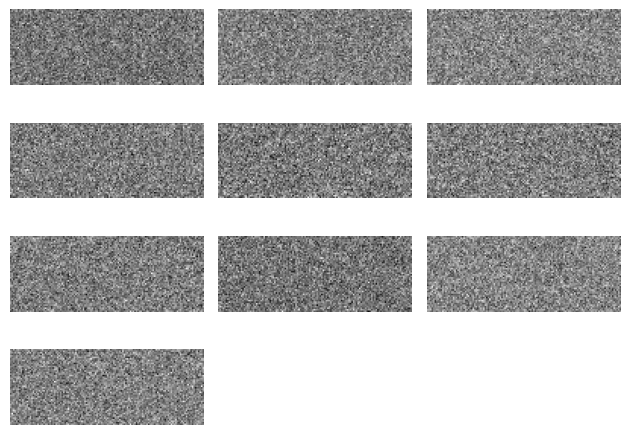

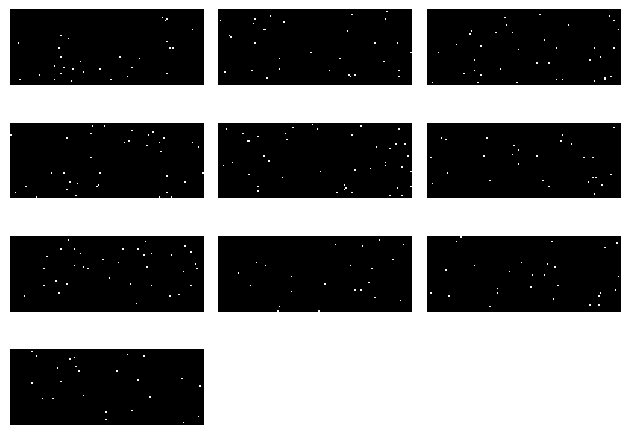

Kernel execution time: 1.4388799667358398 ms


In [ ]:
import torch
import torchshow

# Create events for timing
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)

# Your PyTorch code here
x = torch.randn(10, 50, 128).cuda()
y = torch.randn(10, 50, 128).cuda()

torchshow.show(x)
y = y.transpose(-1, -2)

# Define the sparsity percentage (e.g., 30%)
sparsity_percentage = 99.5
keep_percentage = 100 - sparsity_percentage  # Percentage of values to keep

# Generate a random mask with the desired sparsity
mask = (torch.rand_like(x) < (keep_percentage / 100)).float().cuda()

# Apply the mask to the tensor
sparse_x = x * mask
torchshow.show(mask)


start_event.record()
torch.cuda.synchronize()
sparse_x = sparse_x.to_sparse()
a = torch.bmm(sparse_x, y)
end_event.record()

# Synchronize to ensure the GPU has finished
torch.cuda.synchronize()

# Calculate elapsed time in milliseconds
elapsed_time_ms = start_event.elapsed_time(end_event)

print("Kernel execution time:", elapsed_time_ms, "ms")